In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import functools
import tqdm

In [3]:
device = torch.device('cuda:2') if torch.cuda.is_available() else torch.device('cpu')

def marginal_prob_std(t, sigma):
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2*t)-1.)/2./np.log(sigma))

def diffusion_coeff(t, sigma):
    return torch.tensor(sigma**t, device=device)

sigma = 25.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [4]:
def x_(x_combined, x_perturbed, lambda_, batch_size):
    # print(x_combined.shape)
    # print(x_perturbed.shape)
    x_ = x_combined.to(device) + (lambda_  / 3) * (torch.bmm((torch.ones([batch_size, 1, 1], device=device) * torch.ones([3, 1], device=device)), torch.tensor(x_perturbed).float().to(device)) - torch.bmm((torch.ones([batch_size, 1, 1], device=device) * torch.ones([3, 3]).to(device)), torch.tensor(x_combined).float().to(device)))
    return x_

num_steps = 500
def BSS_sampler(x_perturbed,
                score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                num_steps=num_steps,
                device=device,
                lambda_=0.15,
                eps=1e-3,):
    score_model.eval()
    
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 3, 512, device=device) * marginal_prob_std(t)[:, None, None]
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    # print('x_perturbed shape', x_perturbed.shape)
    with torch.no_grad():
        for time_step in tqdm.notebook.tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            t = t - torch.ones(batch_size, device=device) * step_size + eps
            y = x_perturbed + marginal_prob_std(t)[:, None, None] * torch.randn_like(x_perturbed)
            x = x_(x, y, lambda_, batch_size=batch_size)
            x_mean = x + (g**2)[:, None, None] * score_model(x, batch_time_step) * step_size
            x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None] * torch.randn_like(x)
    return x_mean

# Data 随机得到data

In [16]:
# 
import torch
import matplotlib.pyplot as plt
from datasets_bss import train_dataset, test_dataset
from torch.utils.data import DataLoader, RandomSampler

sample_batch_size = 64
# seed = torch.manual_seed(1001)
# 随机数据  batch_size: 64
train_sampler = RandomSampler(train_dataset(), replacement=False, num_samples=100)
test_sampler = RandomSampler(test_dataset(), replacement=False, num_samples=100)
train_loader = DataLoader(train_dataset(), batch_size=sample_batch_size, sampler=train_sampler)
test_loader = DataLoader(test_dataset(), batch_size=sample_batch_size, sampler=test_sampler)

# 64条随机数据
train_data, train_truth = next(iter(train_loader))
test_data, test_truth = next(iter(test_loader))

# 单条数据 用来画图
randint = torch.randint(0, 64, (1,))
train_data_line = train_data.squeeze(1).to(torch.float32)
train_truth_line = train_truth.squeeze(1).to(torch.float32)

test_data_line = test_data.squeeze(1).to(torch.float32)
test_truth_line = test_truth.squeeze(1).to(torch.float32)


# hijack

In [17]:
# hijack sampling
from model import DW4BSS, DiffWave3
from GAU import DW4BSS_GAU, GAUnet3
from params import params_diffwave_cat, params_diffwave3, params_gau_cat, params_gau3 

model = DW4BSS(params_diffwave_cat, marginal_prob_std_fn).to(device)

try:
    the_ckpt = torch.load(r'/home/wyl/projects/_EEG_score/ckpt/diffwave_cat_ckpt_1.pth')
    model.load_state_dict(the_ckpt)
    print('model loaded')
except:
    print('wrong checkpoint')


sampler = BSS_sampler

train_data = train_data.squeeze(1).to(device)
test_data = test_data.squeeze(1).to(device)
samples = sampler(train_data,
                  model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  device=device)


model loaded


/tmp/ipykernel_3363008/3863884077.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_3363008/3863884077.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)


# Plot and Eval

In [18]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def loss_fn(output, truth):
    loss = F.smooth_l1_loss(output, truth)
    return loss

Text(0.5, 0.98, 'hijack on train data')

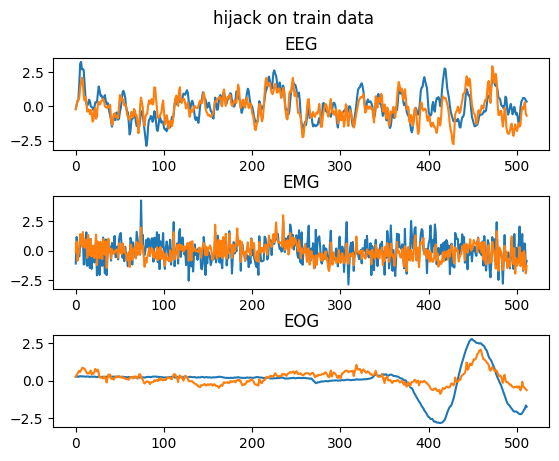

In [20]:
sample = samples[0].cpu()
line1 = sample[0]
line2 = sample[1]
line3 = sample[2]

truth = train_truth.squeeze(1)[0]
truth1 = truth[0]
truth2 = truth[1]
truth3 = truth[2]

fig, axs = plt.subplots(nrows=3, ncols=1)
plt.subplots_adjust(hspace=0.5)
axs[0].plot(truth1)
axs[1].plot(truth2)
axs[2].plot(truth3)

axs[0].plot(line1)
axs[1].plot(line2)
axs[2].plot(line3)

axs[0].set_title('EEG')
axs[1].set_title('EMG')
axs[2].set_title('EOG')

plt.suptitle('hijack on train data')

In [22]:
get_loss = loss_fn(samples.cpu(), train_truth.squeeze(1))
print(get_loss)

tensor(0.3003, dtype=torch.float64)


# Optimize

In [10]:
import numpy as np
import torch

# random search
eps = 1e-3
search_space = np.linspace(1., eps, 100)

hijack = functools.partial(BSS_sampler, 
                #   x_perturbed = perturbed_data,
                  score_model = model,
                  marginal_prob_std = marginal_prob_std_fn,
                  diffusion_coeff = diffusion_coeff_fn,
                  batch_size = sample_batch_size,
                  num_steps = 1000,
                  device=device,
                  eps = 1e-3,)

def grid_search(search_space, x_perturbed, truth):
    best_loss = float('inf')
    best_lambda = None
    for lambda_ in search_space:
        loss = loss_fn(hijack(x_perturbed=x_perturbed, lambda_=lambda_), truth)
        if loss < best_loss:
            best_loss = loss
            best_lambda = lambda_
    return best_lambda, best_loss
